## Uncertainty Estimation

It was shown in the paper that it was possible to obtain reasonably good estimates of the parameters, even with noisy fields values. However, it is crucial for practical application to also have an estimation uncertainty. 

In order to obtain uncertainty estimation values, we need to introduce a Bayesian framework. This requires to introduce some prior distributions over the parameter values. We can immagine to have some nominal values for the components, or at least reasonable guesses or intervals for the values. 

**Proposed Bayesian Solution**:

**MAP estimate** & **Laplace estimate** around the posterior mode. With this approach the prior influences the optimization with via a penalty term on the loss. Gradient based optimization (Adam / LBFGS) can then be employed to find the optimum, which in this case would be the MAP estimate. Finally, we assume the posterior is a Gaussian and we calculate the best fit using the Laplace approximation, which relies on computing the Hessian.

## Prior Distribution Family over the Physical Parameters

In [1]:
from pathlib import Path
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

import h5py
import numpy as np


# change the working directory to the root of the project
sys.path.append(str(Path.cwd().parent))


from pinn_buck.config import Parameters

# load measurement interface
from pinn_buck.io import Measurement
from pinn_buck.noise import add_noise_to_Measurement

from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.model.model_param_estimator import BuckParamEstimator
from pinn_buck.model.trainer import Trainer


from pinn_buck.io import LoaderH5

### Prior distribution family:
We have to consider **Additive vs. Multiplicative Variation**.

* **Additive variation** means the component deviates by **adding or subtracting** some noise:

  $$
  x = x_0 + \epsilon
  \quad\text{(e.g., } \epsilon \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  This is typical of **normal (Gaussian)** noise.

* **Multiplicative variation** means the component value varies by being **scaled** up or down:

  $$
  x = x_0 \cdot (1 + \delta)
  \quad\text{(e.g., } \delta \sim \mathcal{N}(0, \sigma^2)\text{)}
  $$

  Or more generally:

  $$
  \log x \sim \mathcal{N}(\mu, \sigma^2)
  \Rightarrow x \sim \text{LogNormal}(\mu, \sigma^2)
  $$

  This results in a **log-normal distribution** in linear space.

Considering how the components are manufactured:

* Component tolerances are often specified **as a percentage** (e.g., ±5%, ±10%).
* This means that the error **scales** with the magnitude.
* Example:

  * A 1 kΩ resistor with 5% tolerance → 950–1050 Ω
  * A 10 kΩ resistor with 5% tolerance → 9500–10500 Ω
    So the **absolute error grows** with the nominal value.

---

### Implication for Priors

If component values are specified with **percentage tolerances**, then we should model the distributions as:

$$
\log(x) \sim \mathcal{N}(\log(x_0), \sigma^2)
\quad\Rightarrow\quad
x \sim \text{LogNormal}
$$

This ensures:

* **Positivity**
* **Correct scaling of uncertainty**
* **Realistic tails** (e.g., 3σ errors reflect real-world max/min limits)


A log-normal distribution is suitable because:

* All parameters are positive
* Datasheet tolerances are multiplicative (e.g. ±20%)

For each parameter θ:

$$
p(\theta) = \frac{1}{\theta \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log \theta - \mu)^2}{2\sigma^2} \right)
$$

Where:

* μ = log(nominal value)
* σ = log(1 + relative tolerance)

In [2]:
import matplotlib
from scipy.stats import lognorm
from pinn_buck.constants import ParameterConstants, MeasurementGroupArchive
from pinn_buck.data_noise_modeling.auxiliary import rel_tolerance_to_sigma

TRUE_PARAMS = ParameterConstants.TRUE
NOMINAL = ParameterConstants.NOMINAL
REL_TOL = ParameterConstants.REL_TOL
PRIOR_SIGMA = rel_tolerance_to_sigma(REL_TOL, number_of_stds_in_relative_tolerance=1) # transforms relative tolerance to the value of the standard deviation

# print the nominal parameters
print("Nominal Parameters:")
print(NOMINAL)

print("Relative Tolerances:")
print(REL_TOL)

Nominal Parameters:
Parameters(L=0.00068, RL=0.4, C=0.00015, RC=0.25, Rdson=0.25, Rloads=[3.3, 10.0, 6.8], Vin=46.0, VF=1.1)
Relative Tolerances:
Parameters(L=0.5, RL=0.4, C=0.5, RC=0.5, Rdson=0.5, Rloads=[0.3, 0.3, 0.3], Vin=0.3, VF=0.3)


C:\Users\JC28LS\AppData\Local\Temp\ipykernel_28756\2042859499.py:39: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


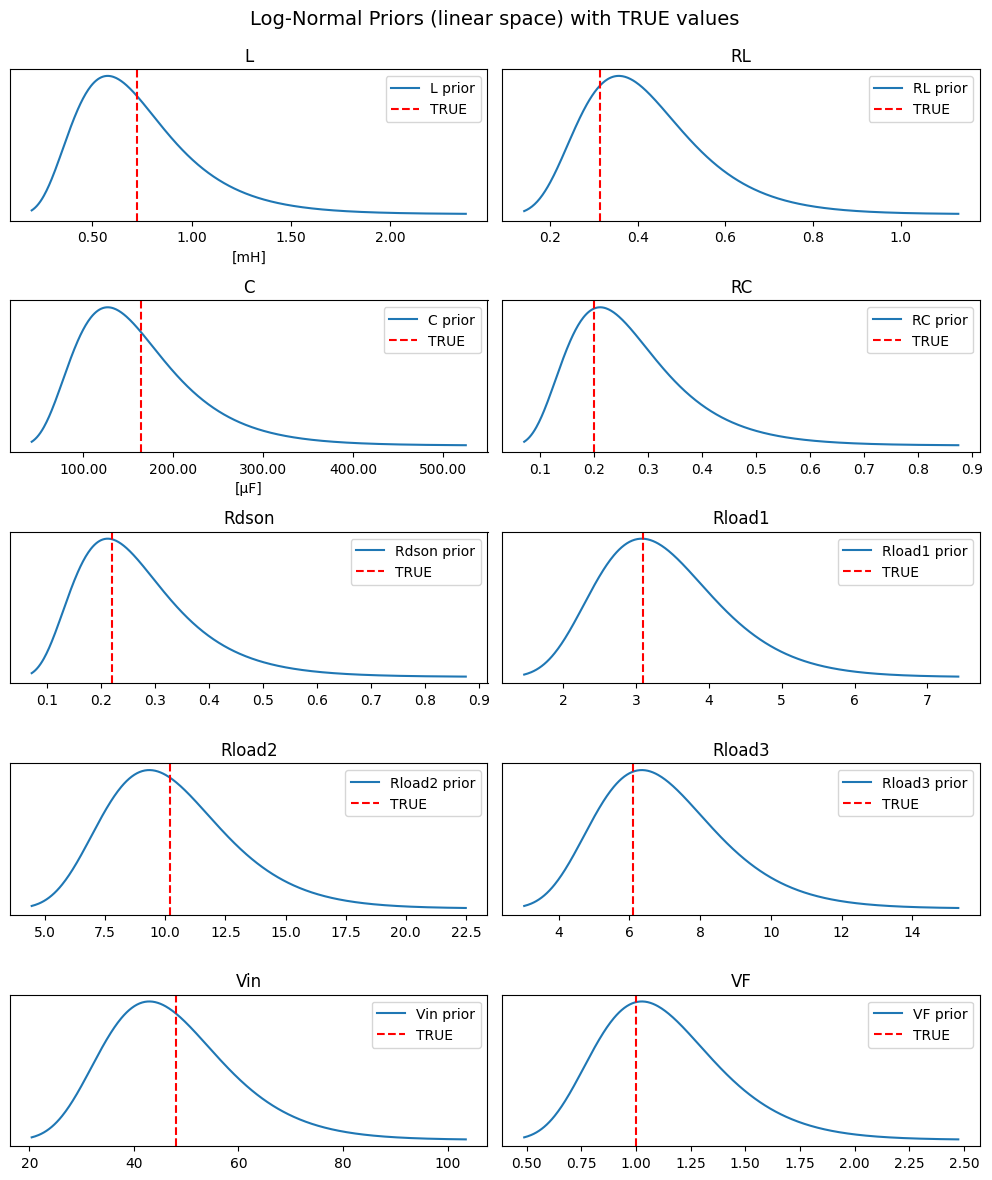

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
# Plotting
ncols = 2
nrows = int(np.ceil(len(NOMINAL) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 12), constrained_layout=True)
axes = axes.flatten()



for ii, ((name, nominal), (_, sigma), (_, true_val)) in enumerate(
    zip(NOMINAL.iterator(), PRIOR_SIGMA.iterator(), TRUE_PARAMS.iterator())
    ):
    
    # log-normal parameters
    mu = np.log(nominal)

    dist = lognorm(s=sigma, scale=np.exp(mu))

    x = np.linspace(dist.ppf(0.001), dist.ppf(0.999), 500)
    pdf = dist.pdf(x)

    ax = axes[ii]
    ax.plot(x, pdf, label=f"{name} prior")
    ax.axvline(true_val, color="red", linestyle="--", label="TRUE")
    ax.set_title(name)
    ax.set_yticks([])
    ax.legend()
    
    if name == "L":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e3:.2f}"))
        ax.set_xlabel("[mH]")
    if name == "C":
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*1e6:.2f}"))
        ax.set_xlabel("[μF]")

fig.suptitle("Log-Normal Priors (linear space) with TRUE values", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.93);

## MAP Estimation

In order to get a MAP estimation, we have to consider the priors and try to maximize the posterior distribution on the parameters following Bayes' rule: 
$$ p(z | x = D) = p(x=D | z) \cdot p(z) / p(x=D) $$
Even in this low dimensional case with 10 latent parameters $z$, which are the physical parameters of the circuit, it is difficult to numerically compute the marginal $$p(x=D) = \int_z p(x=D | z) p(z) dz$$

However, we know that the marginal does not depend on the particular choice of parameters z, so the level set for fixed x=D of the joint $p(x=D, z) = p(x=D | z) \cdot p(z)$ is proportional to the posterior: 
$$ p(z | x = D) \propto  p(x=D, z)$$
Then it is possible to get the MAP solely by analyzing the joint distribution since: 
$$ \argmax_z p(z | x=D) = \argmax_z p(x=D, z)$$

In this application we have a supervised model, so
$$y = f(x, z)$$
And he dataset is $\mathcal D=\{(x_i,\,y_i)\}_{i=0}^{N-1}$.

We can rewrite: 
$$ p(z | x, y = D) \propto  p(y=D_y, z | x=D_x) =  p(y = D_y \mid x, z) p(z)$$

### Definition of the loss function
Now we can elaborate on the expression of the MAP estimate, that searches for $z_{\text{MAP}}=\argmax_z p(y=D, z | x)$. To this end, we chose the Negative Log Likelihood as a loss function

\begin{align}
    \text{NLL}(z) &= - \log p(y=D, z | x) \\
    &= -\log p(y=D | z, x) - \log p(z)
\end{align}

With the hypothesis of independent draws of the observed variables x that form the dataset: 
$$ p(y=D | z, x) = \prod_{i=0}^{N-1} p(y_i | x_i, z) $$


## Consider the choice of Distribution

### Prior
We have chosen a Log-Normal distribution to represent the pdf over the circuit parameters: 
$$p(x) = \frac{1}{x \sigma \sqrt{2\pi}} \exp\left( -\frac{(\log x - \mu)^2}{2\sigma^2} \right)$$

or equivalently $\log x \sim \mathcal{N}(x; \mu, \sigma)$:

$$p(\log x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(\log x - \mu)^2}{2\sigma^2}\right)$$

Then: 
\begin{align}
    \log p(\log z) &= \log \left[\frac{1}{\sqrt{2\pi\sigma_0^2}} \exp\left(-\frac{(\log z - \mu_0)^2}{2\sigma_0^2}\right)\right]\\
                & \propto -\frac{(\log z - \mu_0)^2}{2\sigma_0^2}
\end{align}

Assuming the priors are independently drawn: 
$$
\log p(\log z)= -\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}+\text{const}.
$$



### Likelihood
Assuming the **observations** $\{x_i\}_{i=0}^{N-1}$ are  corrupted by additive homoscedastic Gaussian sensor noise, so the observation random variables are **independent and Gaussian distributed** with a likelihood of the form $y_i \mid x_i,z \;\sim\; \mathcal N\!\bigl(f(x_i,z),\,\sigma_x^{2}\mathbf I\bigr)$, the total log-likelihood is:

$$
\log p(\mathbf y\mid\mathbf x,z)
  = -\frac{1}{2\sigma_x^{2}}\sum_{i=0}^{N-1}\!
      \bigl\|\,y_i-f(x_i,z)\bigr\|^{2} + \text{const}.
$$
Note that $\sigma_x$ is the noise in the observed dataset.  

### NLL - MAP objective
So the nnegative log likelihood becomes: 
$$ \text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.
$$

Note that we assume a fixed variance of the observation that doesn't depend on the values of the input parameters, i.e. we assume **homoschedasticity**. Note that this makes sense: 
    
>  "The parameters determine the mean values of the observed data with some random noise whose variance depends on random factors, independent on the data."

Many times, the prior assumptions are weak and therefore, therefore $\sigma_0$ is allowed to control the data-prior balance entirely. However, in our case we are considering different solutions with different noise powers. Therefore, we should consider both $\sigma_x$ and $\sigma_0$ explicitly. We can rewrite the NLL as: 

$$\text{NLL}(z) = \frac{1}{2\sigma_x^2} \left[
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \frac{\sigma_x^2}{\sigma_0^2} \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2}
\right] + \text{const.}$$

Since $\frac{1}{2\sigma_x^2}$ only changes the scale of the NLL we can ignore this term to obtain:

$$\text{NLL}(z) = \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+ \underbrace{\frac{\sigma_x^2}{\sigma_0^2}}_\lambda \sum_{k=1}^{10}
      \bigl(\log z_k-\mu_{0,k}\bigr)^{2} + \text{const.}$$

Here we can set $\frac{\sigma_x^2}{\sigma_0^2}=\lambda$ and we can see that we obtain a new parameter that regulates how much weights we want to give to the prior. Indeed, if the data is noisy, then $\lambda \uparrow$ and the prior has a stronger influence on the loss, while if the data noise is very low, $\lambda \downarrow$ and we quickly move away from our prior convictions. 

It is common in these setups to directly tune $\lambda$ as a hyperparameter, for example via cross-validation and grid search. However, in our case there is a strong physical interpretation for these quantities and we may have a meaningful insite on the prior range on the parameters from datasheets or manufactorers. Moreover, we may also have some knowledge on the noise present in our measurements. Therefore, we can maintain the original expression for the posterior loss:

$$\text{NLL}(z)=
\frac{1}{2\sigma_x^{2}}
      \sum_{i=0}^{N-1}\!\bigl\|y_i-f(x_i,z)\bigr\|^{2}
+\frac{1}{2}\sum_{k=1}^{10}
      \frac{\bigl(\log z_k-\mu_{0,k}\bigr)^{2}}{\sigma_{0,k}^{2}}
+ \text{const}.$$


## Noisy Observations
We are observing some state signals $x$ and trying to predict $x_{n+1}$ from $x_n$. 


In the previously described model, all observation noise was attributed to the target variable:

$$
y \sim \mathcal{N}(f(x, z), \sigma_x^2).
$$

However, in our specific setup, the target $y = x_{n+1}$ is itself an observed state, and so is the input $x = x_n$. Both are corrupted by measurement noise of the same variance:

$$
x_n^{\text{obs}} = \tilde{x}_n + \eta_n, \quad \eta_n \sim \mathcal{N}(0, \sigma_x^2),
$$

$$
y_n^{\text{obs}} = x_{n+1}^{\text{obs}}.
$$

We use a deterministic model $f(z, x_n)$, typically an RK4 integrator, to predict the next state. The residuals between the noisy target and the prediction are:

$$
r_n(z) = f(z, x_n^{\text{obs}}) - x_{n+1}^{\text{obs}}.
$$

If noise levels were unknown, we could estimate the total predictive variance directly from the residuals:

---

### Analytical Estimation (When Noise is Known)
We have a noisy observation $x^{\text{obs}}\!\sim\!\mathcal N(x,\sigma_x^2)$ and the forward model is a scalar
$y^{\text{obs}}=f(x^{\text{obs}})$.

Let us consider the residual we want to minimize: 
$r_n^{\text{obs}} = x_{n}^{\text{pred}}-x_{n}^{\text{obs}}$

Then we see that: 
$$x_{n}^{\text{pred}} = f(x_{n-1}^{\text{obs}})$$


We can approximate the function with the first order Taylor expansion:
\begin{align}
f(x_{n-1}^{\text{obs}}) &= f(x_{n-1} + \varepsilon_{n-1}) \\
&\simeq f(x_{n-1}) + \frac{\partial f}{\partial x} \varepsilon_{n-1}
\end{align}

Where $\frac{\partial f}{\partial x}$ is the Jacobian $J$
Putting everything together we get: 
\begin{align}
r_n^{\text{obs}} &= f(x_{n-1}) - x_n + J \varepsilon_{n-1} - \varepsilon_{n}\\
&= r_{n} + \epsilon_{r}
\end{align}

So $r_n \sim \mathcal{N}(r_{n}, \Sigma_r)$.

We can calculate the variance by looking at the random variable $\varepsilon_{r} = J \varepsilon_{n-1} - \varepsilon_{n}$. Since we assume the noise on the data is white gaussian noise, so $\varepsilon_{n-1}$ and \varepsilon_{n-1}$ are independent, we get: 

$$\operatorname{Var}[r_n^{\text{obs}}] = ||J||^2 \Sigma_x + \Sigma_x = (1+||J||_F^2) \Sigma_x$$

This decomposition highlights that uncertainty propagates from $x_n$ through the model via its Jacobian with respect to $x$. Thus, even if the model is deterministic, input uncertainty affects the output distribution.

#### Interpretation and Estimation of the Jacobian

Importantly, the Jacobian, i.e. the derivative $\partial f / \partial x$, is **not** a time derivative like $(x_{n+1} - x_n) / dt$. It is a sensitivity derivative that answers the question:

> *"How much would the prediction $f(z, x_n)$ change if I slightly perturbed the input $x_n$?"*

This derivative captures how uncertainty in the current state propagates into uncertainty in the next predicted state.

## Independent v and i noises

In practice the noise levels on v and i can be quite different. Moreover, the estimation of the voltage in the next location will depend on both previous voltage and current as well as the current in the next step will depend on both previous voltage and current. However, the sensitivity to one may be different from the sensitivity to the other. Therefore we have to consider the full 2x2 Jacobian.


#### 2 .  Vector case with diagonal noise

Let the measured state be

$$
x_n^{\text{obs}}=(i_n^{\text{obs}},\,v_n^{\text{obs}})^\top,
\qquad
y_n^{\text{obs}}=(i_{n+1}^{\text{obs}},\,v_{n+1}^{\text{obs}})^\top .
$$

Assume **independent** noises

$$
\Sigma_x=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),\qquad
\Sigma_y=\mathrm{diag}\!\bigl(\sigma_i^{2},\;\sigma_v^{2}\bigr),
$$

and let

$$
J=\frac{\partial f}{\partial x}
=\begin{bmatrix}
J_{11}&J_{12}\\[2pt]
J_{21}&J_{22}
\end{bmatrix}\in\mathbb R^{2\times2}.
$$

The residual covariance is

$$
\boxed{
\Sigma_{\text{tot}}
   =\Sigma_x + J\,\Sigma_x\,J^\top
}
$$


## Forward and Backward Predictions

In the previous derivation we are considering only the forward prediction, which simplifies the mathematics of the model. 

Let's investigate whether the backward prediction is necessary by optimizing the parameters using only the likelihood loss: 

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2}$$

and compare with a term that considers both forward and backward terms: 

$$\sum_{i=0}^{N-1}\!\bigl\|r_n^{\text{fw}}\bigr\|^{2} + \bigl\|r_n^{\text{bw}}\bigr\|^{2}$$


c:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\plot_aux.py:80: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15)


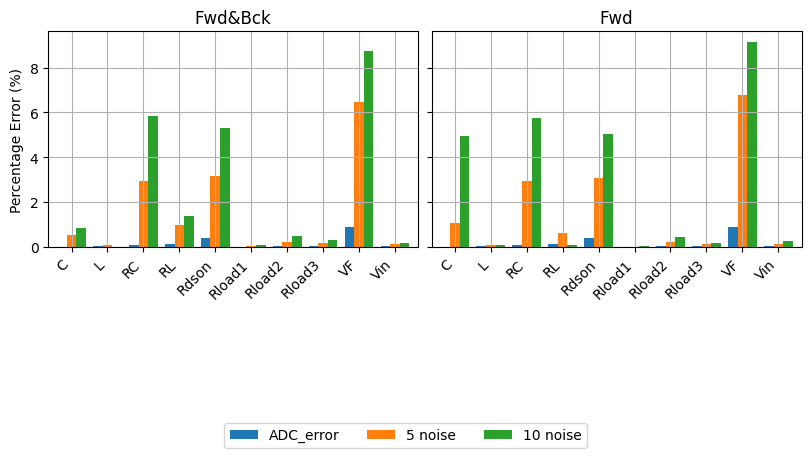

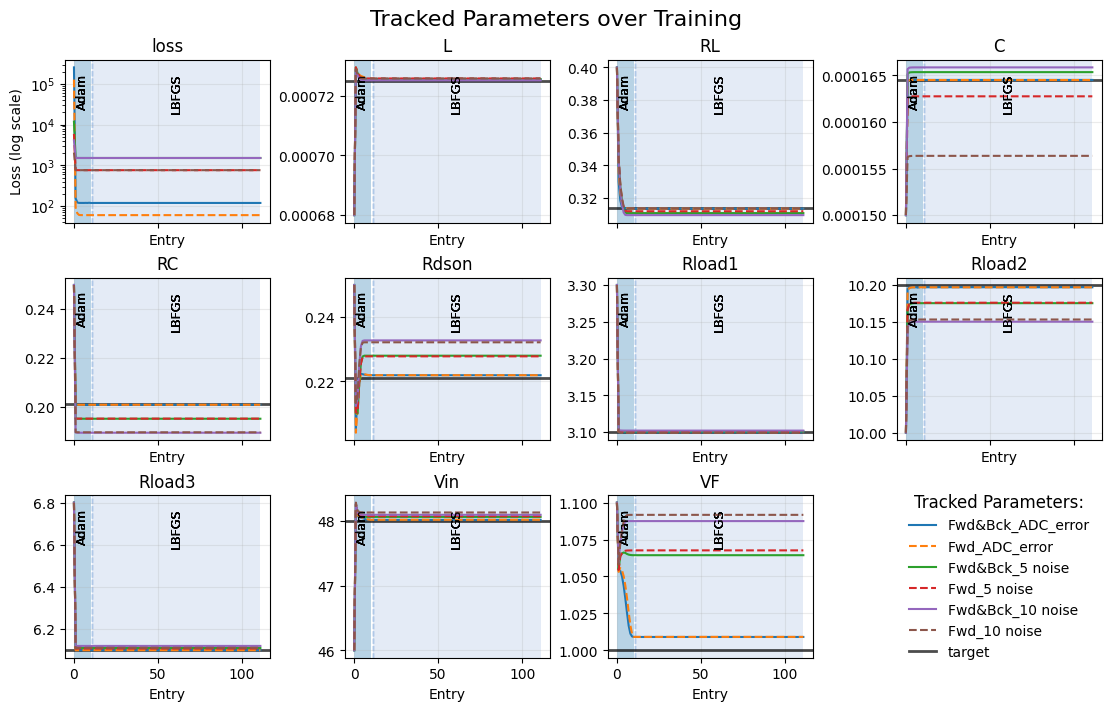

In [13]:
from pinn_buck.model_results.history import TrainingHistory
from pinn_buck.model_results.ploting_comparisons import ResultsComparerTwo
# from pinn_buck.plot_aux import place_shared_legend

rc = ResultsComparerTwo.from_dirs(
    {
        "Fwd&Bck": Path.cwd().parent / "RESULTS" / "Fwd&Bck",
        "Fwd": Path.cwd().parent / "RESULTS" / "Fwd",
    }
)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bbox_to_anchor_vertical=-0.5
);

# Optional: tracked parameters for specific curves


fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels);

It can be seen from the results of the two optimizations that it is **necessary to consider both forward and backward prediction terms** especially to increase robustness to noise in the data.

Let's introduce a statistical interpretation of this setup

### Likelihood with Forward and Backward Residuals

In our parameter estimation model, we simulate both forward and backward time integration using a Runge–Kutta (RK4) solver. At each internal time index $n$, we obtain two residuals:

* The **forward residual**, which compares the next observation to a forward prediction from $x_n$,
* The **backward residual**, which compares the current observation to a backward prediction from $x_{n+1}$:

$$
\begin{aligned}
r_n^{\text{fw}} &= x_{n+1} - f_\rightarrow(x_n, z), \\
r_n^{\text{bw}} &= x_n - f_\leftarrow(x_{n+1}, z),
\end{aligned}
$$

where $f_\rightarrow$ and $f_\leftarrow$ denote RK4 propagation in the forward and backward time directions, respectively. If we assume both residuals are corrupted by independent Gaussian noise with covariance $\sigma_x^2 \mathbf{I}$, then we can treat the two residuals as **independent**, each distributed as:

$$
r_n^{\text{fw}},\, r_n^{\text{bw}} \sim \mathcal{N}(0, \sigma_x^2 \mathbf{I}).
$$

Under this assumption, the log-likelihood over all $N$ internal time steps becomes:

$$
\text{NLL}
= -\frac{1}{2\sigma_x^2} \sum_{n=0}^{N-1}
\left(
\|r_n^{\text{fw}}\|^2 + \|r_n^{\text{bw}}\|^2
\right) + \text{const}.
$$

This corresponds to the **loss function**:

$$
\mathcal{L}_{\text{fw+bw}}(z) = \sum_{n=0}^{N-1}
\left(
\|x_{n+1} - f_\rightarrow(x_n, z)\|^2
+ \|x_n - f_\leftarrow(x_{n+1}, z)\|^2
\right),
$$

and yields the MAP objective:

$$
\text{NLL}(z) =
\frac{1}{2\sigma_x^2} \mathcal{L}_{\text{fw+bw}}(z)
+ \frac{1}{2} \sum_{k=1}^{10}
\frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

If desired, the ratio $\lambda = \sigma_x^2 / \sigma_0^2$ can be treated as a tunable regularization weight on the prior penalty.

> **This is exactly the loss function we have been using with some success!**

---

### Incorporating Residual Correlations

In reality, the residuals $r_n^{\text{fw}}$ and $r_n^{\text{bw}}$ are not independent. Both depend on the same noisy measurements $y_n$ and $y_{n+1}$, and their errors propagate through the respective RK4 solvers. 

Indeed, let us assume the model makes predictions through a (possibly nonlinear) function locally approximated by a **Jacobian** matrix $J_n$, i.e.,

$$
x_{n+1}^{\text{pred}} \approx J_n x_n^{\text{obs}}.
$$

Similarly, the **backward prediction** is modeled as:

$$
x_n^{\text{pred}} \approx J_n^{-1} x_{n+1}^{\text{obs}}.
$$

Assuming the observation noise $\varepsilon_n \sim \mathcal{N}(0, \Sigma_x)$, we have:

* $x_n^{\text{obs}} = x_n^{\text{true}} + \varepsilon_n$
* $x_{n+1}^{\text{obs}} = x_{n+1}^{\text{true}} + \varepsilon_{n+1}$
* with independent noise terms: $\operatorname{Cov}(\varepsilon_n, \varepsilon_{n+1}) = 0$

Then, using the linearized model, we write the residuals as:

$$
r_n^{\text{fw}} = J_n \varepsilon_n - \varepsilon_{n+1}
$$

$$
r_n^{\text{bw}} = J_n^{-1} \varepsilon_{n+1} - \varepsilon_n
$$

### Covariance Matrix Derivation

Now we compute the joint covariance:

$$
\Sigma_r(J_n) = \mathbb{E}[r_n r_n^\top]
$$

Write it block-wise:

$$
\Sigma_r(J_n) = \begin{pmatrix}
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{fw}})^\top] & \mathbb{E}[r_n^{\text{fw}} (r_n^{\text{bw}})^\top] \\
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{fw}})^\top] & \mathbb{E}[r_n^{\text{bw}} (r_n^{\text{bw}})^\top]
\end{pmatrix}
$$

Compute each block:

---

### Top-left: forward–forward

$$
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{fw}})^\top]
= \mathbb{E}[(J_n \varepsilon_n - \varepsilon_{n+1})(J_n \varepsilon_n - \varepsilon_{n+1})^\top]
= J_n \Sigma_x J_n^\top + \Sigma_x
$$

---

### Bottom-right: backward–backward

$$
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{bw}})^\top]
= \mathbb{E}[(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)^\top]
= J_n^{-1} \Sigma_x J_n^{-\top} + \Sigma_x
$$

---

### Top-right: forward–backward

$$
\mathbb{E}[r_n^{\text{fw}} (r_n^{\text{bw}})^\top]
= \mathbb{E}[(J_n \varepsilon_n - \varepsilon_{n+1})(J_n^{-1} \varepsilon_{n+1} - \varepsilon_n)^\top]
$$

Expanding:

$$
= -J_n \mathbb{E}[\varepsilon_n \varepsilon_n^\top] - \mathbb{E}[\varepsilon_{n+1} \varepsilon_{n+1}^\top] J_n^{-\top}
= -J_n \Sigma_x - \Sigma_x J_n^{-\top}
$$

---

### Bottom-left: backward–forward

This is the transpose of the top-right block:

$$
\mathbb{E}[r_n^{\text{bw}} (r_n^{\text{fw}})^\top]
= -\Sigma_x J_n^\top - J_n^{-1} \Sigma_x
$$

---

### Final Covariance Matrix

$$
\Sigma_r(J_n) = \begin{pmatrix}
J_n \Sigma_x J_n^\top + \Sigma_x & -J_n \Sigma_x - \Sigma_x J_n^{-\top} \\
-\Sigma_x J_n^\top - J_n^{-1} \Sigma_x & J_n^{-1} \Sigma_x J_n^{-\top} + \Sigma_x
\end{pmatrix}
$$

---

## Sanity Check: $J_n \approx I$

If $J_n = I$, the Jacobian is the identity:

* $J_n \Sigma_x J_n^\top = \Sigma_x$
* $J_n^{-1} = I$
* $J_n^{-\top} = I$

Substitute into the expression:

$$
\Sigma_r(I) = \begin{pmatrix}
2\Sigma_x & -2\Sigma_x \\
-2\Sigma_x & 2\Sigma_x
\end{pmatrix}
$$

---

### Interpretation

* The **diagonal blocks** $2\Sigma_x$ reflect that each residual includes two independent noise contributions.
* The **off-diagonal blocks** $-2\Sigma_x$ indicate **perfect anti-correlation** between the forward and backward residuals when the model is identity: if one step is overestimated, the other is underestimated symmetrically.
* This makes sense because the backward step essentially inverts the forward step—any error in one direction propagates oppositely in the reverse direction.
* In probabilistic terms, this anti-correlation reduces the effective uncertainty when combining forward and backward information—a key feature that can be exploited in inference (e.g., smoother estimates, better likelihoods).


This covariance structure is crucial when computing a likelihood or Mahalanobis loss over stacked forward-backward residuals.

### Intuitive Example

Suppose the system is one-dimensional, so $\Sigma_x = \sigma^2$, and $J_n = 1$ (i.e., identity dynamics).

Let’s consider what happens when **observation noise perturbs $x_n^{\text{obs}}$ upward**:

* Assume the true state is $x_n = 1.0$, but due to noise, the observation is $x_n^{\text{obs}} = 1.1$ (i.e., a positive error).
* The forward model is $x_{n+1}^{\text{pred}} = J_n x_n^{\text{obs}} = 1.1$
* But let the true value be $x_{n+1} = 1.0$, and suppose the observed value $x_{n+1}^{\text{obs}} \approx 1.0$

Then:

* **Forward residual**:

  $$
  r_n^{\text{fw}} = x_{n+1}^{\text{pred}} - x_{n+1}^{\text{obs}} \approx 1.1 - 1.0 = +0.1
  $$

* **Backward prediction**:

  $$
  x_n^{\text{pred}} = J_n^{-1} x_{n+1}^{\text{obs}} = 1.0
  $$

* **Backward residual**:

  $$
  r_n^{\text{bw}} = x_n^{\text{pred}} - x_n^{\text{obs}} = 1.0 - 1.1 = -0.1
  $$

So we observe:

* $r_n^{\text{fw}} = +0.1$
* $r_n^{\text{bw}} = -0.1$

They are **perfectly anti-correlated**, which is exactly what the off-diagonal blocks $-2\Sigma_x$ represent in expectation.

## Putting all Together
The corresponding log-likelihood for each time step becomes:

$$
\log p(r_n \mid z) =
- \frac{1}{2} r_n^\top \Sigma_r(J_n)^{-1} r_n
- \frac{1}{2} \log \det \Sigma_r(J_n) + \text{const}.
$$

The second term is constant with respect to the residuals so we neglect it. 
Summing over all steps and adding the log-prior gives the complete MAP objective:

$$
\text{NLL}(z) =
\frac{1}{2}
\sum_{n=0}^{N-1}
r_n^\top \Sigma_r(J_n)^{-1} r_n
+ \frac{1}{2} \sum_{k=1}^{10}
\frac{(\log z_k - \mu_{0,k})^2}{\sigma_{0,k}^2}
+ \text{const}.
$$

This is a **statistically efficient generalization** of the independent residual loss. 


### Our Application

In our case, each measurement $y_n = [i_n, v_n]^\top$ is a 2D vector containing the current and voltage of the converter. Consequently, the residuals $r_n^{\text{fw}}, r_n^{\text{bw}} \in \mathbb{R}^2$, and each Jacobian $J_n\in\mathbb{R}^{2\times 2}$. Therefore, the full residual vector $r_n \in \mathbb{R}^4$, and the block covariance matrix $\Sigma_r(J_n)\in\mathbb{R}^{4\times 4}$.

### Optimizing on the Full Sigma matrix can be problematic

c:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\plot_aux.py:80: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15)


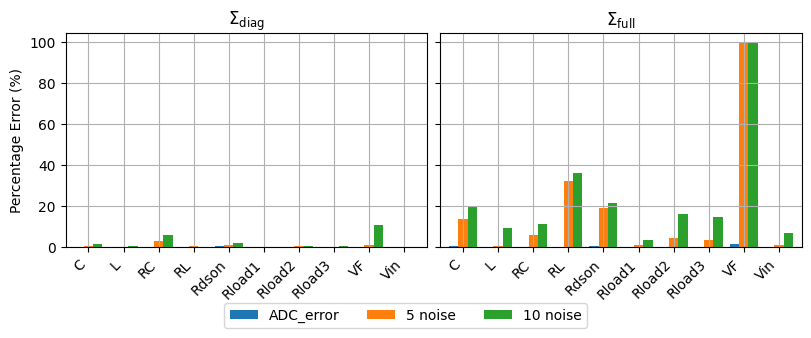

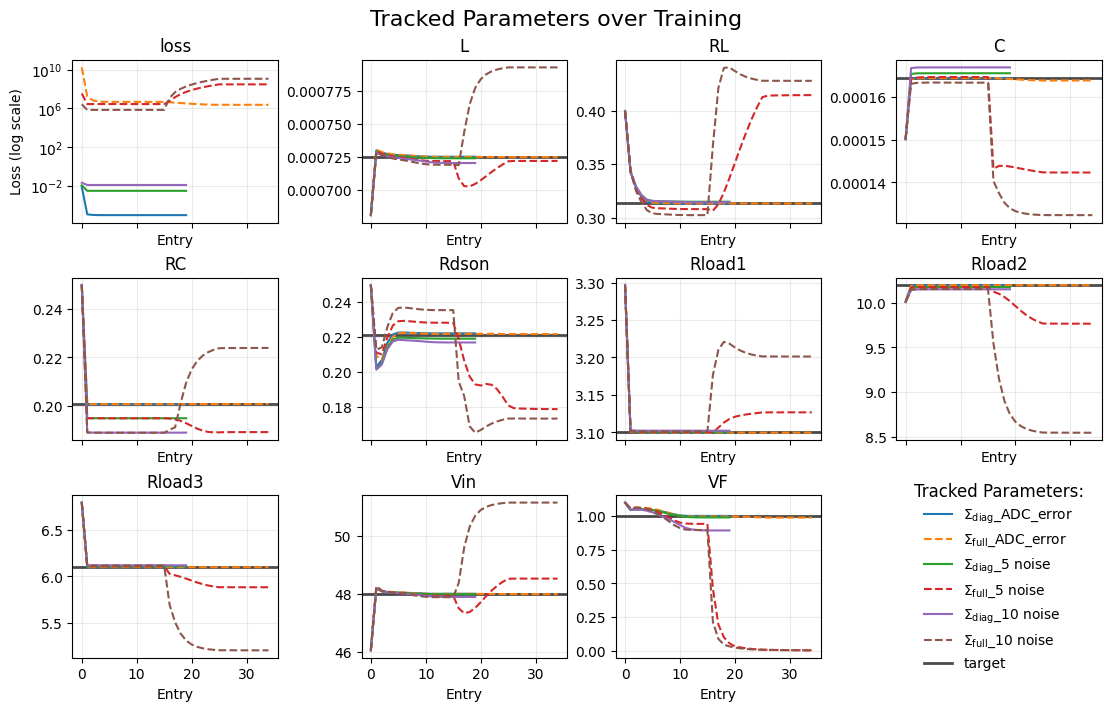

In [5]:
# loop through all CSV files in the directory
fb_outdir = (
    Path.cwd().parent / "RESULTS" / "Testing" / "forward_vs_forward&backward" / "forward&backward"
)
fbm_outdir = (
    Path.cwd().parent
    / "RESULTS"
    / "Testing"
    / "forward_vs_forward&backward"
    / "f&b_matrix_loss_form"
)


rc = ResultsComparerTwo.from_dirs(
    {"$\\Sigma_{\\text{diag}}$": fb_outdir, "$\\Sigma_{\\text{full}}$": fbm_outdir}
)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(labels=labels, target=TRUE_PARAMS, select_lowest_loss=False)

# Optional: tracked parameters for specific curves


fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels)

## Why ADAM fails with the full covariance matrix?

---

### Chapter: Why Adam Fails with Full-Covariance Mahalanobis Loss

#### 🧭 1. Background: Preconditioning and Curvature

In optimization, a **preconditioner** $P$ is used to transform gradients before stepping, effectively rescaling the loss landscape to reduce condition number and accelerate convergence. In quadratic minimization, the ideal preconditioner is $H^{-1}$, the inverse Hessian. Preconditioned gradient descent then becomes:

$$\theta_{t+1} = \theta_t - \eta P \nabla \mathcal{L}(\theta_t)$$

resulting in spherical level curves and stable convergence **if** $P\approx H^{-1}$.

---

#### 2. Adam’s Diagonal-Only Preconditioner

Adam adapts learning rates per-parameter using first and second moment estimates:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \quad
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2,$$

with update:

$$\theta_{t+1} = \theta_t - \eta \cdot \frac{m_t}{\sqrt{v_t} + \epsilon}.$$

Here, the preconditioner $P_t^{-1} = \eta\,\operatorname{diag}(1/\sqrt{v_t+\epsilon})$ is **diagonal**, i.e., Adam rescales each parameter independently.

---

#### 3. The Problem: Full-Covariance Loss Requires a Full Preconditioner

When using a **full covariance Mahalanobis loss**

$$\mathcal{L}(\theta) = \tfrac{1}{2}\sum_n r_n(\theta)^\top \Sigma_r^{-1} r_n(\theta),$$

the Hessian becomes

$$H = \sum_n J_n^\top \Sigma_r^{-1} J_n,$$

where $J_n$ is the Jacobian of the residuals. Since $\Sigma_r^{-1}$ contains off-diagonal blocks, $H$ becomes **rotated**—its eigenvectors don’t align with parameter axes.

Because Adam only applies diagonal scaling, it fails to align with these rotated eigenvectors. As a result:

* In directions with **high curvature**, Adam overshoots, causing divergence.
* In directions with **low curvature**, Adam undershoots, stalling progress.

This mismatch between the optimizer’s axis-aligned scaling and the true anisotropic loss landscape leads to instability.

---

### Detailed illustration with Toy Example - Hessian Rotation explained

Consider a two–parameter toy model

$$
\theta=(a,b), \qquad r(\theta)=\begin{bmatrix}a\\[2pt] b\end{bmatrix}.
$$

The Mahalanobis loss is

$$
\boxed{\;\mathcal{L}(a,b)=\tfrac12\,r^\top \Sigma^{-1} r\;}.
$$

---

#### a. Diagonal precision ( $\Sigma^{-1}=I$ )

**Loss**

$$
\mathcal{L}_{\text{diag}}=\tfrac12\,(a^{2}+b^{2}).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{diag}}
      =\begin{bmatrix}a\\[2pt]b\end{bmatrix}.
$$

Each component depends *only* on its own coordinate:
 • changing $a$ leaves $\partial\mathcal L/\partial b$ unchanged, and vice-versa.
Hence the gradient vector points along the coordinate axes: for fixed $b$ we move purely in the $a$-direction, etc.

**Hessian**

$$
H_{\text{diag}}
      =\begin{pmatrix}1&0\\0&1\end{pmatrix}.
$$

Eigenvectors are exactly the parameter axes
$e_a=(1,0)^\top,\;e_b=(0,1)^\top$.
Adam’s diagonal preconditioner matches this geometry perfectly.

---

#### b. Full precision with correlation ( $\Sigma^{-1}=\begin{smallmatrix}1&\rho\\ \rho&1\end{smallmatrix}$, $\rho=0.9$ )

**Loss**

$$
\mathcal{L}_{\text{full}}
  =\tfrac12\bigl(a^{2}+b^{2}+2\rho\,ab\bigr).
$$

**Gradient**

$$
\nabla\mathcal{L}_{\text{full}}
  =\begin{bmatrix}
     a+\rho\,b\\
     b+\rho\,a
    \end{bmatrix}.
$$

Each partial derivative now couples both coordinates.
For example, the $a$-component is $a+\rho\,b$; if $b\neq 0$ the gradient for $a$ already has a “tilt” proportional to $b$.
Thus the gradient direction is **not aligned** with the axes unless $b=0$.

**Hessian**

$$
H_{\text{full}}
      =\begin{pmatrix}1&\rho\\[2pt]\rho&1\end{pmatrix}.
$$

Compute its eigen-decomposition:

* Eigenvalues
  $\lambda_{1}=1+\rho,\quad\lambda_{2}=1-\rho$.
* Orthogonal eigenvectors

$$
v_{1}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\1\end{bmatrix},
\quad
v_{2}=\tfrac{1}{\sqrt2}\begin{bmatrix}1\\-1\end{bmatrix}.
$$

Both eigenvectors are **rotated ± 45°** relative to the parameter axes.
Minimising the quadratic ideally moves along $v_1$ (steep) and $v_2$ (shallow).

---

#### c. Why Adam’s update becomes inefficient

Adam rescales each coordinate independently:

$$
\theta_{t+1}
  =\theta_t-\eta\,D^{-1}\,\nabla\mathcal{L}(\theta_t),
\qquad
D=\operatorname{diag}\!\bigl(\sqrt{v_t}+\varepsilon\bigr).
$$

No off-diagonal terms ⇒ **no rotation of the gradient**.
In the full-Σ case:

* Along the steep direction $v_1$: components on $a$ and $b$ must be updated **together** to descend. Adam scales them separately, so one coordinate often overshoots, the other undershoots.
* Along the shallow direction $v_2$: Adam’s per-coordinate learning rate is too small, progress slows dramatically.

The mismatch between $D^{-1}$ (axis-aligned) and $H_{\text{full}}^{-1}$ (rotated) creates oscillations or divergence, observed as a rising loss after the switch.

---

#### Takeaway

* **Diagonal Σ** → Hessian is diagonal → gradient and eigenvectors align with parameter axes → Adam works.
* **Full Σ with off-diagonal ρ** → Hessian eigenvectors are rotated → Adam’s diagonal preconditioner cannot align → optimisation becomes unstable.

For such full-covariance losses we need either
(1) a **full preconditioner** (whitening, LBFGS, K-FAC) or
(2) a gradual blend from diagonal to full covariance, or
(3) keep Adam for MAP, then apply a Laplace/posterior step with the full $\Sigma$.

## LBFGS Might Work

* **How it works** LBFGS stores the most recent $m$ pairs of parameter displacements $s_k=\theta_{k+1}-\theta_k$ and gradient differences $y_k=g_{k+1}-g_k$.
  Using these pairs it builds a low-rank approximation $H_k^{-1}$ to the inverse Hessian that satisfies

  $$
  H_k^{-1} y_k = s_k \quad\text{(secant condition)}.
  $$
* **Why it helps** Although the memory size $m$ is small (e.g. 10–20), the matrix $H_k^{-1}$ is **dense** in the sub-space spanned by recent updates.  This captures **cross-parameter curvature** ignored by Adam.  Consequently, LBFGS produces steps that are automatically rotated into the valley directions of the Mahalanobis loss, reducing overshoot and speeding convergence.
* **Practical note** LBFGS uses line search (or a trust region) that adapts step length to local curvature, further mitigating divergence in steep directions.


#### Advantages

1. **Curvature matching** – LBFGS supplies a preconditioner $P$ that better approximates $H^{-1}$.
2. **Rotated updates** – Off-diagonal information lets the optimizer move simultaneously along coupled parameters, following the true valley floor.
3. **Condition-number reduction** – Effective condition number after preconditioning is $\kappa(PH)\ll\kappa(H)$, so step sizes need not shrink catastrophically.
4. **Less manual tuning** – Because the step is curvature-aware, aggressive learning-rate decay after introducing the full $\Sigma_r$ is often unnecessary.

In short, LBFGS supplies a **data-driven dense inverse-Hessian estimate** in low memory.


## Block-Diagonalized Covariance Optimization

Since it is challenging to optimize with the full covariance matrix, let's start by optimizing with a covariance matrix holding only the diagonal blocks.

$$
\Sigma_r(J_n) = \begin{pmatrix}
J_n \Sigma_x J_n^\top + \Sigma_x & 0 \\
0 & J_n^{-1} \Sigma_x J_n^{-\top} + \Sigma_x
\end{pmatrix}
$$

In [6]:
from typing import Callable, Iterable
import torch

from pinn_buck.io import LoaderH5
from pinn_buck.parameter_transformation import make_log_param, reverse_log_param
from pinn_buck.model.model_param_estimator import BuckParamEstimator, BaseBuckEstimator
from pinn_buck.model.loss_function_archive import (
    build_map_loss,
    fw_bw_loss_whitened,
    diag_second_order_loss,
)
from pinn_buck.data_noise_modeling.jacobian_estimation import estimate_Jacobian
from pinn_buck.data_noise_modeling.auxiliary import rel_tolerance_to_sigma
from pinn_buck.data_noise_modeling.covariance_matrix_blocks_funcs import (
    covariance_matrix_on_standard_residuals,
)
from pinn_buck.data_noise_modeling.covariance_matrix_auxil import (
    generate_residual_covariance_matrix,
    chol,
    chol_inv,
)

# %%
## Noise Power
lsb_i = 10 / (2**12 - 1)  # 10 A full-scale current
lsb_v = 30 / (2**12 - 1)  # 30 V full-scale voltage

# i and v noise levels should probably be considered separately:

sigma_noise_ADC_i = 1 * lsb_i  # 1 LSB noise
sigma_noise_5_i = 5 * lsb_i  # 5 LSB noise
sigma_noise_10_i = 10 * lsb_i  # 10 LSB noise

sigma_noise_ADC_v = 1 * lsb_v  # 1 LSB noise
sigma_noise_5_v = 5 * lsb_v  # 5 LSB noise
sigma_noise_10_v = 10 * lsb_v  # 10 LSB noise

noise_power_ADC_i = sigma_noise_ADC_i**2
noise_power_5_i = sigma_noise_5_i**2
noise_power_10_i = sigma_noise_10_i**2

noise_power_ADC_v = sigma_noise_ADC_v**2
noise_power_5_v = sigma_noise_5_v**2
noise_power_10_v = sigma_noise_10_v**2


# load measurements
db_dir = Path(r"C:/Users/JC28LS/OneDrive - Aalborg Universitet/Desktop/Work/Databases")
h5filename = "buck_converter_Shuai_processed.h5"
io = LoaderH5(db_dir, h5filename)

### the jacobians are independent of the measurement so we can calculate them once
io.load("10 noise")
device = "cpu"
X = torch.tensor(io.M.data, device=device)
model = BuckParamEstimator(param_init=NOMINAL).to(device)

jacobians_stack_fwd = estimate_Jacobian(
    model, X, direction="forward", by_series=True, number_of_samples=500, dtype=torch.float64
)

jacobians_stack_bck = estimate_Jacobian(
    model, X, direction="backward", by_series=True, number_of_samples=500, dtype=torch.float64
)
for i in range(jacobians_stack_fwd.shape[0]):
    print(f"Transient {i+1}:")
    print("Forward Jacobian:\n", jacobians_stack_fwd[i])
    print("Backward Jacobian:\n", jacobians_stack_bck[i])
    print("-" * 40)




# crop the jacobians to be 2x2: only noise on i and v
jacobians_stack_fwd = jacobians_stack_fwd[:, :2, :2]
jacobians_stack_bck = jacobians_stack_bck[:, :2, :2]


def make_transient_covariance_matrices(
    data_covariance: Tuple[float, float],
    residual_covariance_block_func: Callable,
    jac_fwd: Iterable[torch.Tensor],
    jac_bck: Iterable[torch.Tensor],
    inlcude_diag_terms: bool = False,
    damp: float = 1e-7,
    dtype: torch.dtype = torch.float64,
) -> torch.Tensor:
    # check the number of fwd and bck jacobians is the same
    if len(jac_fwd) != len(jac_bck):
        raise ValueError("Number of forward and backward Jacobians must be the same.")
    covariance_matrices = []
    for jac_fwd_i, jac_bck_i in zip(jac_fwd, jac_bck):
        cov_matrix = generate_residual_covariance_matrix(
            data_covariance=data_covariance,
            residual_covariance_block_func=residual_covariance_block_func,
            jac_fwd=jac_fwd_i,
            jac_bck=jac_bck_i,
            include_diag_terms=inlcude_diag_terms,
            damp=damp,
            dtype=dtype,
        )
        covariance_matrices.append(cov_matrix)
    return torch.stack(covariance_matrices)  # (T, 2, 2)


covariance_matrices_adc = make_transient_covariance_matrices(
    data_covariance=(noise_power_ADC_i, noise_power_ADC_v),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=False,
    damp=1e-7,
    dtype=torch.float64,
)

covariance_matrices_5 = make_transient_covariance_matrices(
    data_covariance=(noise_power_5_i, noise_power_5_v),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=False,
    damp=1e-7,
    dtype=torch.float64,
)

covariance_matrices_10 = make_transient_covariance_matrices(
    data_covariance=(noise_power_10_i, noise_power_10_v),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=False,
    damp=1e-7,
    dtype=torch.float64,
)


# print the covariance matrices for each transient


def print_transient_covariance_matrices(covariance_matrices: torch.Tensor):
    for i in range(covariance_matrices.shape[0]):
        print(f"Transient {i+1} Covariance Matrix:")
        print(covariance_matrices[i])


for name, matrices in zip(
    ["ADC noise", "5 LSB noise", "10 LSB noise"],
    [covariance_matrices_adc, covariance_matrices_5, covariance_matrices_10],
):
    print(f"Covariance matrices for {name}:")
    print_transient_covariance_matrices(matrices)
    print("-" * 40)

L_adc = chol(covariance_matrices_adc)
L_5 = chol(covariance_matrices_5)
L_10 = chol(covariance_matrices_10)


### Build full covariance matrices from the block builders

covariance_matrices_adc_full = make_transient_covariance_matrices(
    data_covariance=torch.tensor([noise_power_ADC_i, noise_power_ADC_v]),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=True,
    damp=1e-7,
    dtype=torch.float64,
)

covariance_matrices_5_full = make_transient_covariance_matrices(
    data_covariance=torch.tensor([noise_power_5_i, noise_power_5_v]),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=True,
    damp=1e-7,
    dtype=torch.float64,
)

covariance_matrices_10_full = make_transient_covariance_matrices(
    data_covariance=torch.tensor([noise_power_10_i, noise_power_10_v]),
    residual_covariance_block_func=covariance_matrix_on_standard_residuals,
    jac_fwd=jacobians_stack_fwd,
    jac_bck=jacobians_stack_bck,
    inlcude_diag_terms=True,
    damp=1e-7,
    dtype=torch.float64,
)


# print the full covariance matrices
for name, matrices in zip(
    ["ADC noise", "5 LSB noise", "10 LSB noise"],
    [covariance_matrices_adc_full, covariance_matrices_5_full, covariance_matrices_10_full],
):
    print(f"Full Covariance Matrix for {name}:")
    print(matrices)
    print("-" * 40)

L_adc_full = chol(covariance_matrices_adc_full)
L_5_full = chol(covariance_matrices_5_full)
L_10_full = chol(covariance_matrices_10_full)


Transient 1:
Forward Jacobian:
 tensor([[ 9.7742e-01, -3.5321e-02,  1.6344e+00, -8.0568e+03],
        [ 1.4438e-01,  9.4335e-01,  4.9946e-01,  1.0538e+03]],
       dtype=torch.float64)
Backward Jacobian:
 tensor([[ 1.0174e+00,  3.8203e-02, -1.6837e+00,  7.8231e+03],
        [-1.5614e-01,  1.0541e+00, -2.6509e-01, -2.1771e+03]],
       dtype=torch.float64)
----------------------------------------
Transient 2:
Forward Jacobian:
 tensor([[ 9.7779e-01, -3.5908e-02,  1.6843e+00, -4.0664e+03],
        [ 1.5415e-01,  9.7225e-01,  5.4486e-01, -1.7915e+03]],
       dtype=torch.float64)
Backward Jacobian:
 tensor([[ 1.0168e+00,  3.7569e-02, -1.7333e+00,  4.0497e+03],
        [-1.6128e-01,  1.0226e+00, -2.8462e-01,  1.1662e+03]],
       dtype=torch.float64)
----------------------------------------
Transient 3:
Forward Jacobian:
 tensor([[ 9.7767e-01, -3.5767e-02,  1.6692e+00, -5.3829e+03],
        [ 1.5177e-01,  9.6521e-01,  5.3267e-01,  1.2064e+03]],
       dtype=torch.float64)
Backward Jacobian

In [7]:
# %%
from typing import Dict
from pinn_buck.model.trainer import Trainer, TrainingConfigs
from pinn_buck.constants import ParameterConstants, MeasurementGroupArchive
from pinn_buck.model.trainer import Trainer, TrainingConfigs
from pinn_buck.laplace_posterior_fitting import LaplaceApproximator, LaplacePosterior

def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)
out_dir = Path.cwd().parent / "RESULTS" / "Fwd&Bck"

# generate this directory if it is not already present
out_dir.mkdir(parents=True, exist_ok=True)

run_configs = TrainingConfigs(
    lr_adam=1e-3,
    epochs_adam=10_000,
    device="cpu",
    patience=3000,
    lr_reduction_factor_adam=0.5,
    epochs_lbfgs=100,
    lr_lbfgs=1,
    history_size_lbfgs=20,
    max_iter_lbfgs=100,
    clip_gradient_adam=1e6,
    save_every_lbfgs=1,
)

l_dict = {
    1: L_adc,  # ADC error
    3: L_5,  # 5 noise
    4: L_10,  # 10 noise
}
l_dict_full = {
    1: L_adc_full,  # ADC error
    3: L_5_full,  # 5 noise
    4: L_10_full,  # 10 noise
}

S_dict_full = {
    1: covariance_matrices_adc_full,  # ADC error
    3: covariance_matrices_5_full,  # 5 noise
    4: covariance_matrices_10_full,  # 10 noise
}


noisy_measurements = {}
trained_models: Dict[str, BuckParamEstimator] = {}
trained_runs: Dict[str, Trainer] = {}
laplace_posteriors: Dict[str, LaplacePosterior] = {}
inverse = False

# Load the data from the hdf5 file
io = LoaderH5(db_dir, h5filename)

for idx, group_number in enumerate(l_dict.keys()):
    group_name = MeasurementGroupArchive.SHUAI_ORIGINAL[group_number]
    if "Sync" in group_name:
        # Skip the Sync Error group for now
        continue
    print(f"Loading group {group_number}: {group_name}")
    io.load(group_name)

    # Store the measurement in a dictionary
    noisy_measurements[group_name] = io.M

    print(f"\n{'-'*50}")
    print(f"{idx}) Training with {group_name} data")

    # Train the model on the noisy measurement
    X = torch.tensor(io.M.data, device=device)
    model = BuckParamEstimator(param_init=NOMINAL).to(device)

    chol_L = l_dict[group_number]  # Cholesky factor of the noise covariance matrix
    chol_L_full = l_dict_full[group_number]  # Cholesky factor of the full noise covariance matrix

    sig_r = S_dict_full[group_number]  # full noise covariance matrix

    trainer = Trainer(
        model=model,
        loss_fn=build_map_loss(
            initial_params=NOMINAL,
            initial_uncertainty=PRIOR_SIGMA,
            loss_likelihood_function=fw_bw_loss_whitened,  # loss function for the forward-backward pass
            L=chol_L,  # Cholesky factor of the diagonal noise covariance matrix
            weight_prior_loss=2 # seen as the fw and bw losses are correlated
        ),
        cfg=run_configs,
        device=device,
    )

    trainer.fit(X=X)
    trainer.print_summary()

    ### fit a Laplace Approximator for the posterior
    print("Fitting Laplace Posterior")
    laplace_posterior_approx = LaplaceApproximator(
        model=trainer.optimized_model(),
        loss_fn=build_map_loss(
            initial_params=NOMINAL,
            initial_uncertainty=PRIOR_SIGMA,
            loss_likelihood_function=fw_bw_loss_whitened,  # loss function for the forward-backward pass
            L=chol_L,  # Cholesky factor of the diagonal noise covariance matrix
            weight_prior_loss=2,  # seen as the fw and bw losses are correlated
        ),
        device=device,
        damping=1e-7,
    )
    laplace_posterior = laplace_posterior_approx.fit(X)

    laplace_posteriors[group_name] = laplace_posterior
    trained_models[group_name] = trainer.optimized_model()
    trained_runs[group_name] = trainer.history

    # save the best parameters for each run
    # trainer.history.get_best_parameters("Adam").save(out_dir / f"best_params_{group_name}_Adam.json")
    # trainer.history.get_best_parameters("LBFGS").save(out_dir / f"best_params_{group_name}_LBFGS.json")
    trainer.history.get_best_parameters().save(out_dir / f"best_params_{group_name}.json")
    trainer.history.save_to_csv(out_dir / f"history_{group_name}.csv")
    print("\n \n \n")

Loading group 1: ADC_error

--------------------------------------------------
0) Training with ADC_error data
[Adam] Iteration 0, gradient_norm  nan, loss 2.554725e+05,
Parameters: L=6.800e-04, RL=4.000e-01, C=1.500e-04,  RC=2.500e-01, Rdson=2.500e-01,  Rloads=[3.300e+00, 1.000e+01, 6.800e+00],  Vin=46.000, VF=1.100e+00
[Adam] Iteration 1000, gradient_norm 1.051399e+03, loss 1.544153e+02,
Parameters: L=7.286e-04, RL=3.301e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.051e-01,  Rloads=[3.100e+00, 1.019e+01, 6.099e+00],  Vin=48.111, VF=1.054e+00
[Adam] Iteration 2000, gradient_norm 2.796285e+02, loss 1.220760e+02,
Parameters: L=7.272e-04, RL=3.187e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.173e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.073, VF=1.054e+00
[Adam] Iteration 3000, gradient_norm 4.109864e+01, loss 1.190630e+02,
Parameters: L=7.266e-04, RL=3.145e-01, C=1.645e-04,  RC=2.008e-01, Rdson=2.219e-01,  Rloads=[3.100e+00, 1.020e+01, 6.099e+00],  Vin=48.057, VF=1.050e+00
[Adam] I

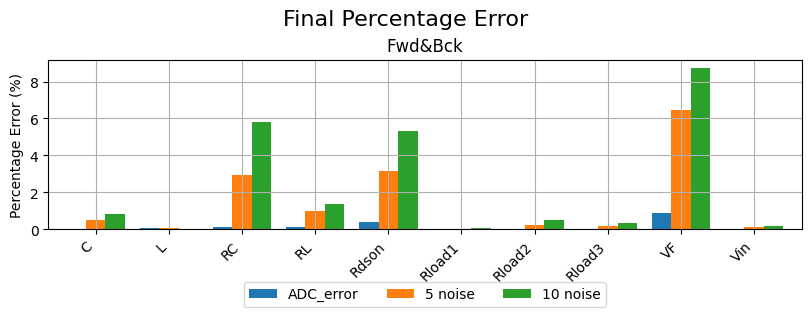

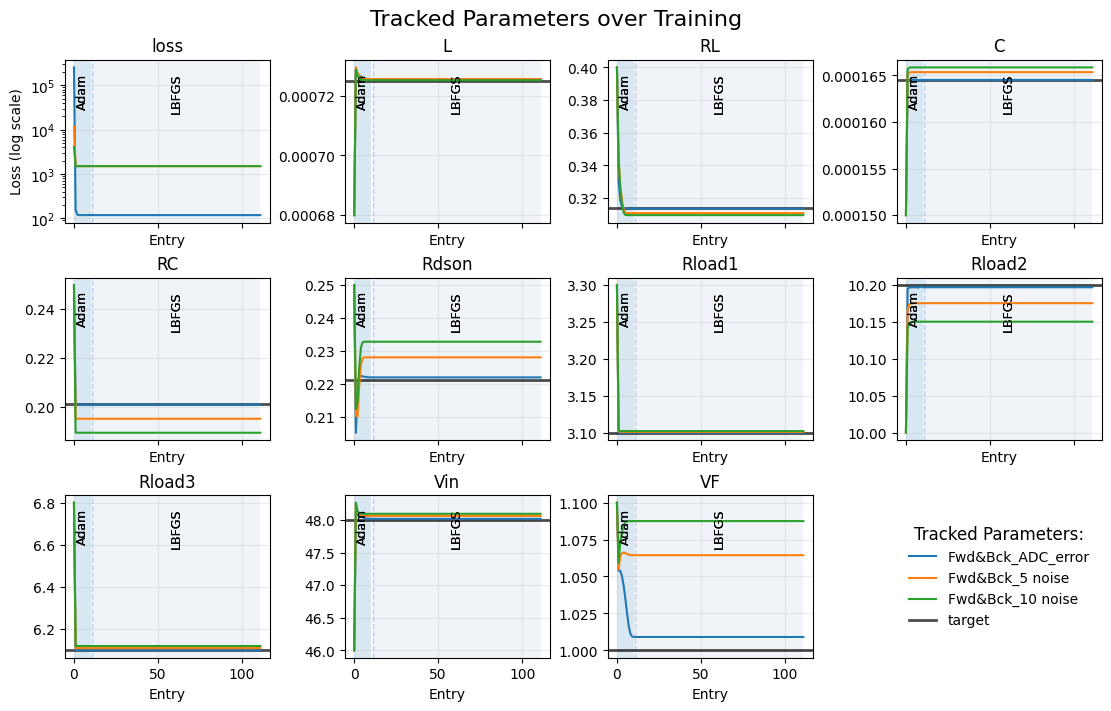

In [8]:
rc = ResultsComparerTwo.from_dirs({"Fwd&Bck": out_dir})

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(
    labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bbox_to_anchor_vertical=-0.5
)

# Optional: tracked parameters for specific curves


fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels)

c:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\buck_converter_estimator\pinn_buck\plot_aux.py:80: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.15)


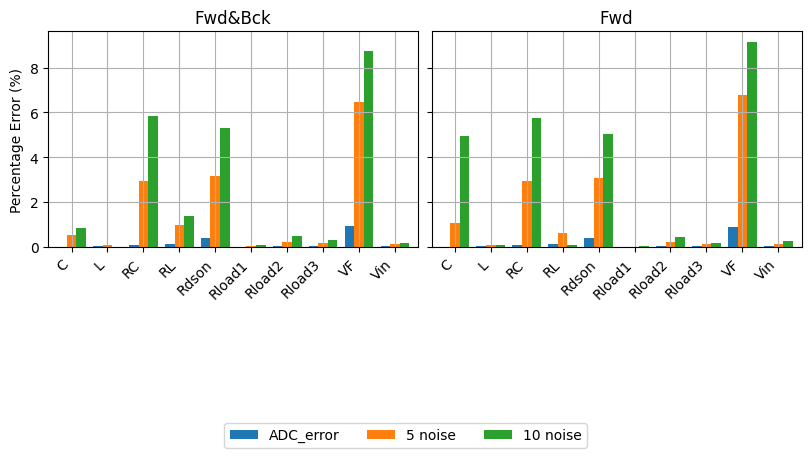

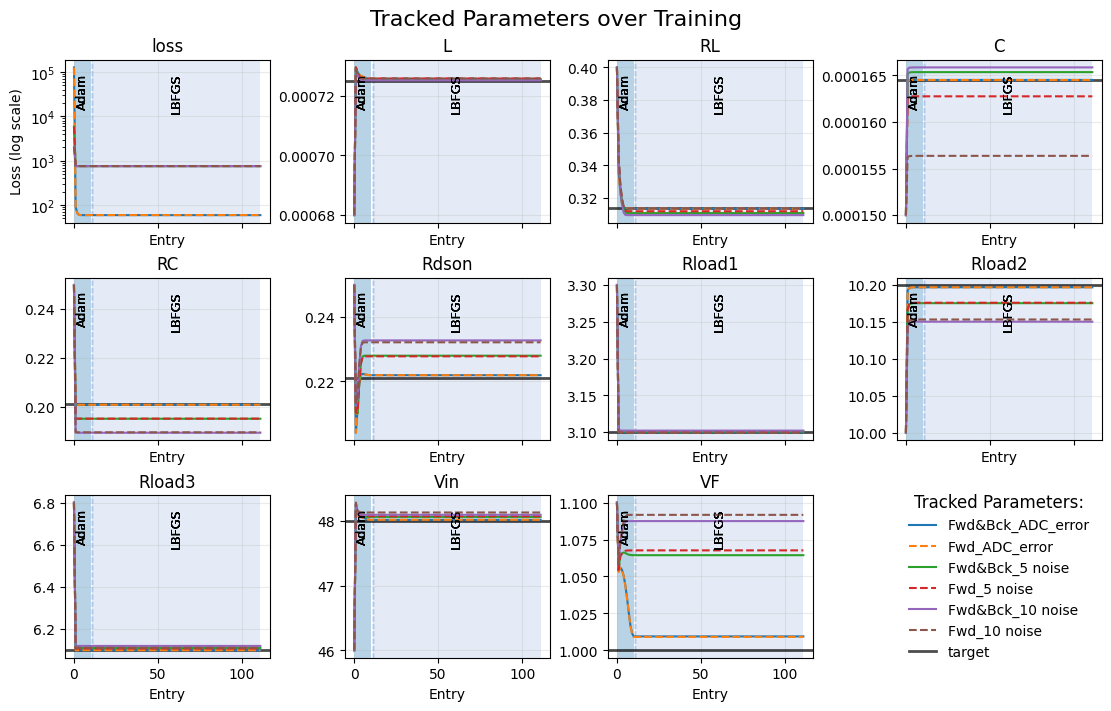

In [ ]:
rc = ResultsComparerTwo.from_dirs(
    {
        "Fwd&Bck": Path.cwd().parent / "RESULTS" / "Fwd&Bck",
        "Fwd": Path.cwd().parent / "RESULTS" / "Fwd",
    }
)

# Choose the labels you care about (ints map via the default dict; strings work too)
labels = ("ADC_error", "5 noise", "10 noise")

# Final % error comparison (side-by-side)
fig, ax = rc.plot_comparison(labels=labels, target=TRUE_PARAMS, select_lowest_loss=True, legend_bbox_to_anchor_vertical=-0.5)

# Optional: tracked parameters for specific curves


fig, axes = rc.plot_tracked(target=TRUE_PARAMS, labels=labels)

In [9]:
# Print Laplace posterior parameter estimates

print("Laplace Posterior Parameter Estimates:")
for label, lfit in laplace_posteriors.items():
    print(f"\nParameter estimates for {label}:")
    print("LOGNORMAL APPROX:")
    lfit.print_param_uncertainty("lognormal")
    print("GAUSSIAN APPROX:")
    lfit.print_param_uncertainty("gaussian")
    print("\n\n")

Laplace Posterior Parameter Estimates:

Parameter estimates for ADC_error:
LOGNORMAL APPROX:
L         : 7.254e-04  -2.6e-06/+2.6e-06  (-0.36 %, +0.36 %)
RL        : 3.137e-01  -2.9e-03/+2.9e-03  (-0.92 %, +0.92 %)
C         : 1.645e-04  -1.1e-06/+1.1e-06  (-0.68 %, +0.68 %)
RC        : 2.008e-01  -5.2e-04/+5.2e-04  (-0.26 %, +0.26 %)
Rdson     : 2.220e-01  -3.4e-03/+3.4e-03  (-1.54 %, +1.54 %)
Rload1    : 3.100e+00  -1.9e-03/+1.9e-03  (-0.06 %, +0.06 %)
Rload2    : 1.020e+01  -2.0e-02/+2.0e-02  (-0.19 %, +0.19 %)
Rload3    : 6.099e+00  -7.1e-03/+7.1e-03  (-0.12 %, +0.12 %)
Vin       : 4.802e+01  -8.7e-02/+8.7e-02  (-0.18 %, +0.18 %)
VF        : 1.013e+00  -9.0e-02/+9.0e-02  (-8.93 %, +8.92 %)
GAUSSIAN APPROX:
L         : 7.254e-04  ±2.6e-06  (0.36 %)
RL        : 3.136e-01  ±2.9e-03  (0.92 %)
C         : 1.645e-04  ±1.1e-06  (0.68 %)
RC        : 2.008e-01  ±5.2e-04  (0.26 %)
Rdson     : 2.219e-01  ±3.4e-03  (1.54 %)
Rload1    : 3.100e+00  ±1.9e-03  (0.06 %)
Rload2    : 1.020e+01  ±2.0e

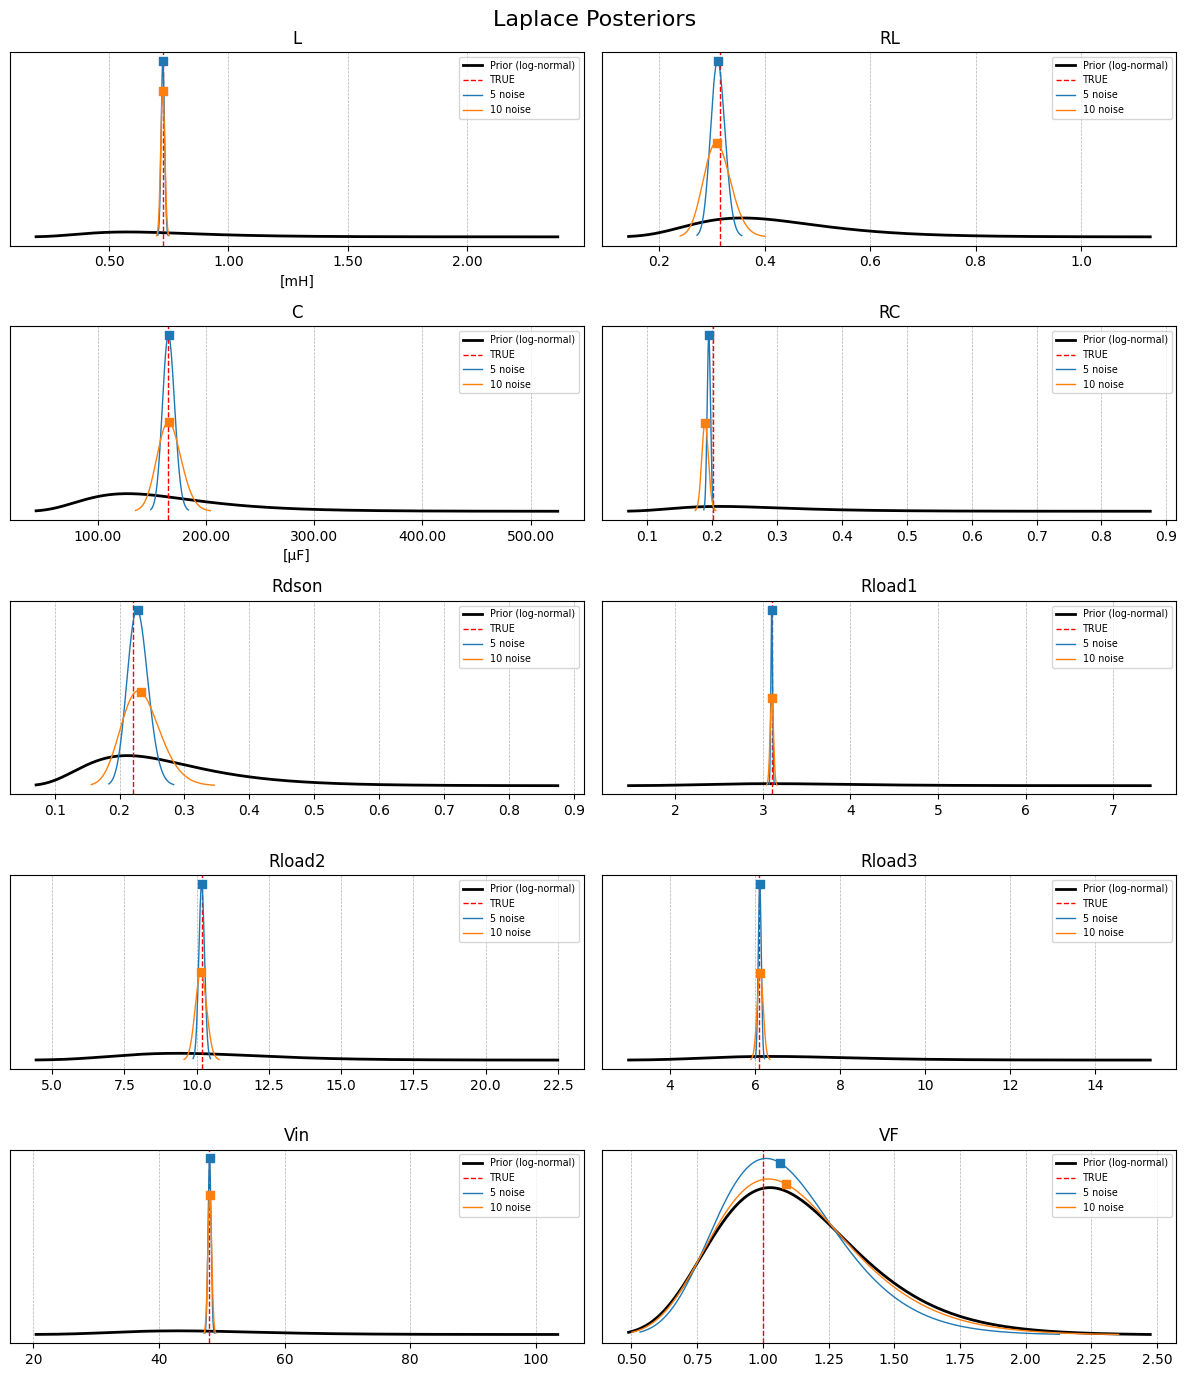

In [10]:
from pinn_buck.laplace_posterior_plotting import LaplacePosteriorPlotter

LaplacePosteriorPlotter.plot_all_laplace_posteriors_grid(
    lfits=laplace_posteriors,
    style="log-normal",
    skip_labels=("ADC_error",)
);